<a href="https://colab.research.google.com/github/vmadalasa/EVAConsolidated/blob/master/EVAS12/Madhu_VM_new_EVA_S12_TinyImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.72GB
Available: 9.13GB
Used: 3.69GB
Percentage: 28.2%


In [3]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'

--2020-06-27 07:44:43--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  65.3MB/s    in 4.4s    

2020-06-27 07:44:48 (53.3 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
!pip install albumentations==0.4.5 --quiet

     |████████████████████████████████| 122kB 3.0MB/s 
     |████████████████████████████████| 634kB 5.3MB/s 


In [18]:
!nvidia-smi

Sat Jun 27 12:30:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    59W / 149W |   8107MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [15]:
device = 'cuda'
from Res18 import ResNet18

In [16]:
model = ResNet18().to(device)

In [17]:
# Import the required classes from the drive

from dataloader2 import Imagenet_data_loader
from extrautils import extrautils
import train_test


In [10]:
# Tiny IMagenet Download
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 26.32 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


In [19]:
# Define Variables

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []


batch_size = 256
num_workers = 4
root_path = 'IMagenet/tiny-imagenet-200/'
class_file = 'wnids.txt'
class_desc_file = 'words.txt'
split_perc = 0.7                # Split Percentage for Train and Test Data set

train_folder = 'IMagenet/tiny-imagenet-200/train'
val_folder = 'IMagenet/tiny-imagenet-200/val/'
val_file = 'IMagenet/tiny-imagenet-200/val/val_annotations.txt'

In [21]:
classes = []
classes_desc = {}
train_data = []
train_labels = []
test_data = []
test_labels = []


# Obtain the classes, Class Description, Train_data and Validation_data via the library
# This is gneric code to get any train/validation data and shuffle them together
classes =extrautils.read_class (root_path=root_path, filename=class_file)
classes_desc = extrautils.read_class_desc (root_path=root_path, filename=class_desc_file)


train_data, train_labels = extrautils.get_train_data(root_path, classes = classes)
val_data, val_labels = extrautils.get_val_data(root_path)

All_data = train_data+val_data
All_labels = train_labels + val_labels


train_data, train_labels, val_data, val_labels = extrautils.data_shuffle_and_split (All_data, All_labels, split_perc)

In [22]:
# Define the Data Transform ad Dataset
trans = Imagenet_data_loader.data_transform_train()

tinyimagenet_dataset = Imagenet_data_loader.image_folder(folder_path=train_folder, transform=trans)
# Obtain the Train and Test data set from the tiny image net data set with a split percentage
train_set, val_set = extrautils.dataset_shuffle_and_split (dataset=tinyimagenet_dataset ,split_perc= 0.7)


In [23]:
# Define Train and Test Data Loader from Train set/Test set split above
train_loader = Imagenet_data_loader.data_loader(dataset=train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = Imagenet_data_loader.data_loader(dataset=val_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)
print(len(train_loader))
print(len(test_loader))
#display(train_loader,64)

274
118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


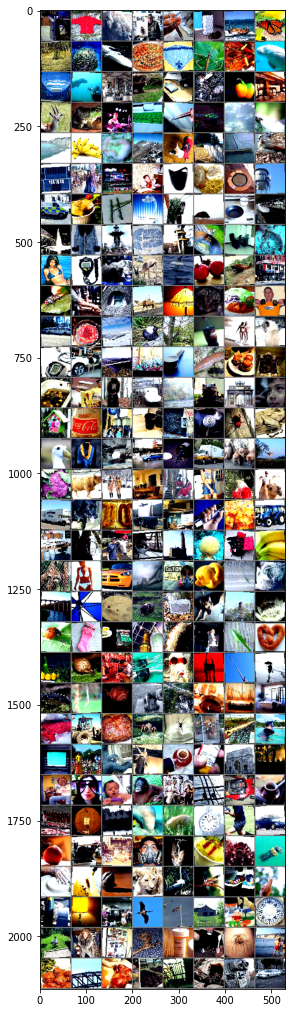

In [24]:
import matplotlib.pyplot as plt
import numpy as np


# Display Images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(28,18))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [25]:
# Check the Model Summary - Parameters used and memory consumed. 
!pip install torchsummary

from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = ResNet18().to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

In [26]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau, StepLR
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)  
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [27]:
# Run the Model for 50 Epochs and obtain the Train/Text Accuracies
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    a,b = train_test.train(model, device, train_loader, optimizer, epoch)
    train_losses.extend(a)
    train_accuracy.extend(b)
    c,d = train_test.test(model, device, test_loader)
    test_losses.extend(c)
    test_accuracy.extend(d)
    scheduler.step()
    print('')

  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 2782/30000 (9.27%)


EPOCH: 2


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 4675/30000 (15.58%)


EPOCH: 3


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 5170/30000 (17.23%)


EPOCH: 4


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0142, Accuracy: 5697/30000 (18.99%)


EPOCH: 5


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 7374/30000 (24.58%)


EPOCH: 6


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 7903/30000 (26.34%)


EPOCH: 7


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 8408/30000 (28.03%)


EPOCH: 8


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 9769/30000 (32.56%)


EPOCH: 9


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 9239/30000 (30.80%)


EPOCH: 10


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0125, Accuracy: 8620/30000 (28.73%)


EPOCH: 11


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 9336/30000 (31.12%)


EPOCH: 12


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 9951/30000 (33.17%)


EPOCH: 13


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 9275/30000 (30.92%)


EPOCH: 14


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 10179/30000 (33.93%)


EPOCH: 15


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 10138/30000 (33.79%)


EPOCH: 16


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 16273/30000 (54.24%)


EPOCH: 17


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 16331/30000 (54.44%)


EPOCH: 18


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 16322/30000 (54.41%)


EPOCH: 19


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 16193/30000 (53.98%)


EPOCH: 20


Loss=0.724 Batch_id=273 Accuracy=87.85: 100%|██████████| 274/274 [08:05<00:00,  1.77s/it]



Test set: Average loss: 0.0076, Accuracy: 16073/30000 (53.58%)


